# Sampling
* Sometimes we need to test the model performance, but we can not use the same data as training and testing. therefore we need sampling strategies.
*   **Training error** (blue line): Training error, also known as in-sample error, is the error that occurs when a model is applied to the data it was trained on.
*   **Testing error** (red line): Testing error, or out-of-sample error, is the error that occurs when the model is applied to a new dataset that it hasn't seen before, often a validation or test set.  

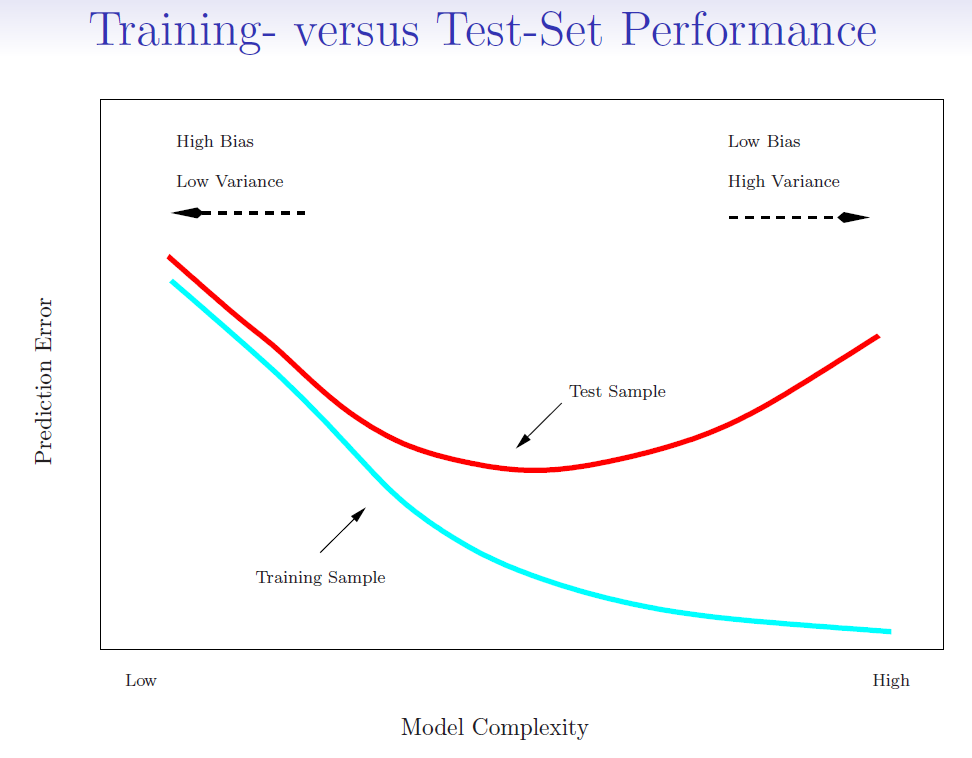

## Estimate Testing error
* When we use training error to estimate testing error, we often get a **underestimated** result. Some methods make a **mathematical adjustment** to the training error rate in order to estimate the test error rate.

### AIC (Akaike Information Criterion)
$$
AIC=2k-2ln(L)
$$
* $k$ is the number of parameters in the model
* $L$ is the maximum value of the likelihood function for the model

### BIC (Bayesian Information Criterion)
$$
BIC=ln(n)k-2ln(L)
$$
* $n$ is the number of observations
* The other terms are as defined for AIC
### Example 
* Want to compare linear vs higher-order polynomial terms in a linear regression

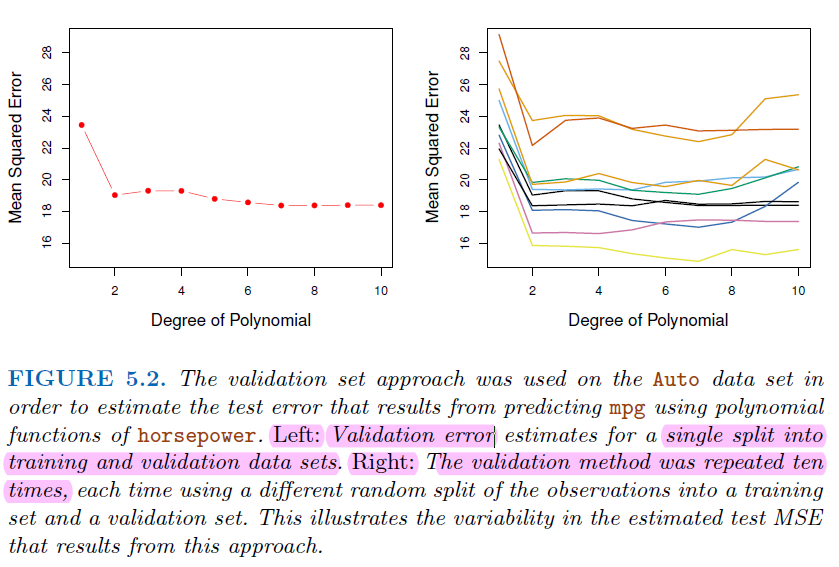

In [1]:
import numpy as np
import statsmodels.api as sm

In [2]:
# Generate some data
np.random.seed(0)
X = np.random.uniform(-10, 10, 100)
Y = 3 - 2*X + X**2 + np.random.normal(0, 2, 100)

# Fit models of varying complexity
results = {}
for degree in range(1, 6):
    features = np.column_stack([X**i for i in range(1, degree + 1)])
    features = sm.add_constant(features)
    model = sm.OLS(Y, features).fit()
    results[degree] = {'model': model, 'AIC': model.aic, 'BIC': model.bic}

# Find the best model according to AIC and BIC
best_by_aic = min(results, key=lambda k: results[k]['AIC'])
best_by_bic = min(results, key=lambda k: results[k]['BIC'])

print(f'Best model by AIC is of degree {best_by_aic} with AIC = {results[best_by_aic]["AIC"]}')
print(f'Best model by BIC is of degree {best_by_bic} with BIC = {results[best_by_bic]["BIC"]}')

Best model by AIC is of degree 2 with AIC = 425.7373213865948
Best model by BIC is of degree 2 with BIC = 433.55283194455905


## Cross Validation
* In normal validation approach, **only a subset of the observation are used to fit the model**
    * The validation error may tend to **overestimate the test error** for the model fit on the entire data set


### K-fold Cross Validation
* Let the $K$ parts be $C_1,C_2,...,C_K$, where $C_k$ denotes the indices of the observations in part $k$. There're $n_k$ observations in part k, where $n_k=n/K$
* Compute (regression)
$$
CV_{(K)}=\sum_{k=1}^K\frac{n_k}{n}MSE_k
$$

* For Classification, Compute
    * Where $Err_k = \sum_{i\in C_k}I(y_i\neq \hat{y_i})/n_k$ 
$$
CV_{(K)}=\sum_{k=1}^K\frac{n_k}{n}Err_k
$$
* basically the weighted sum of $MSE_k$ by number of observations in $k$
* Since each training set is only $(K-1)/K$, the **estimates of prediction error will typically be biased upward**.
* $K=5$ or $10$ provides a good compromise for bias-variance tradeoff.

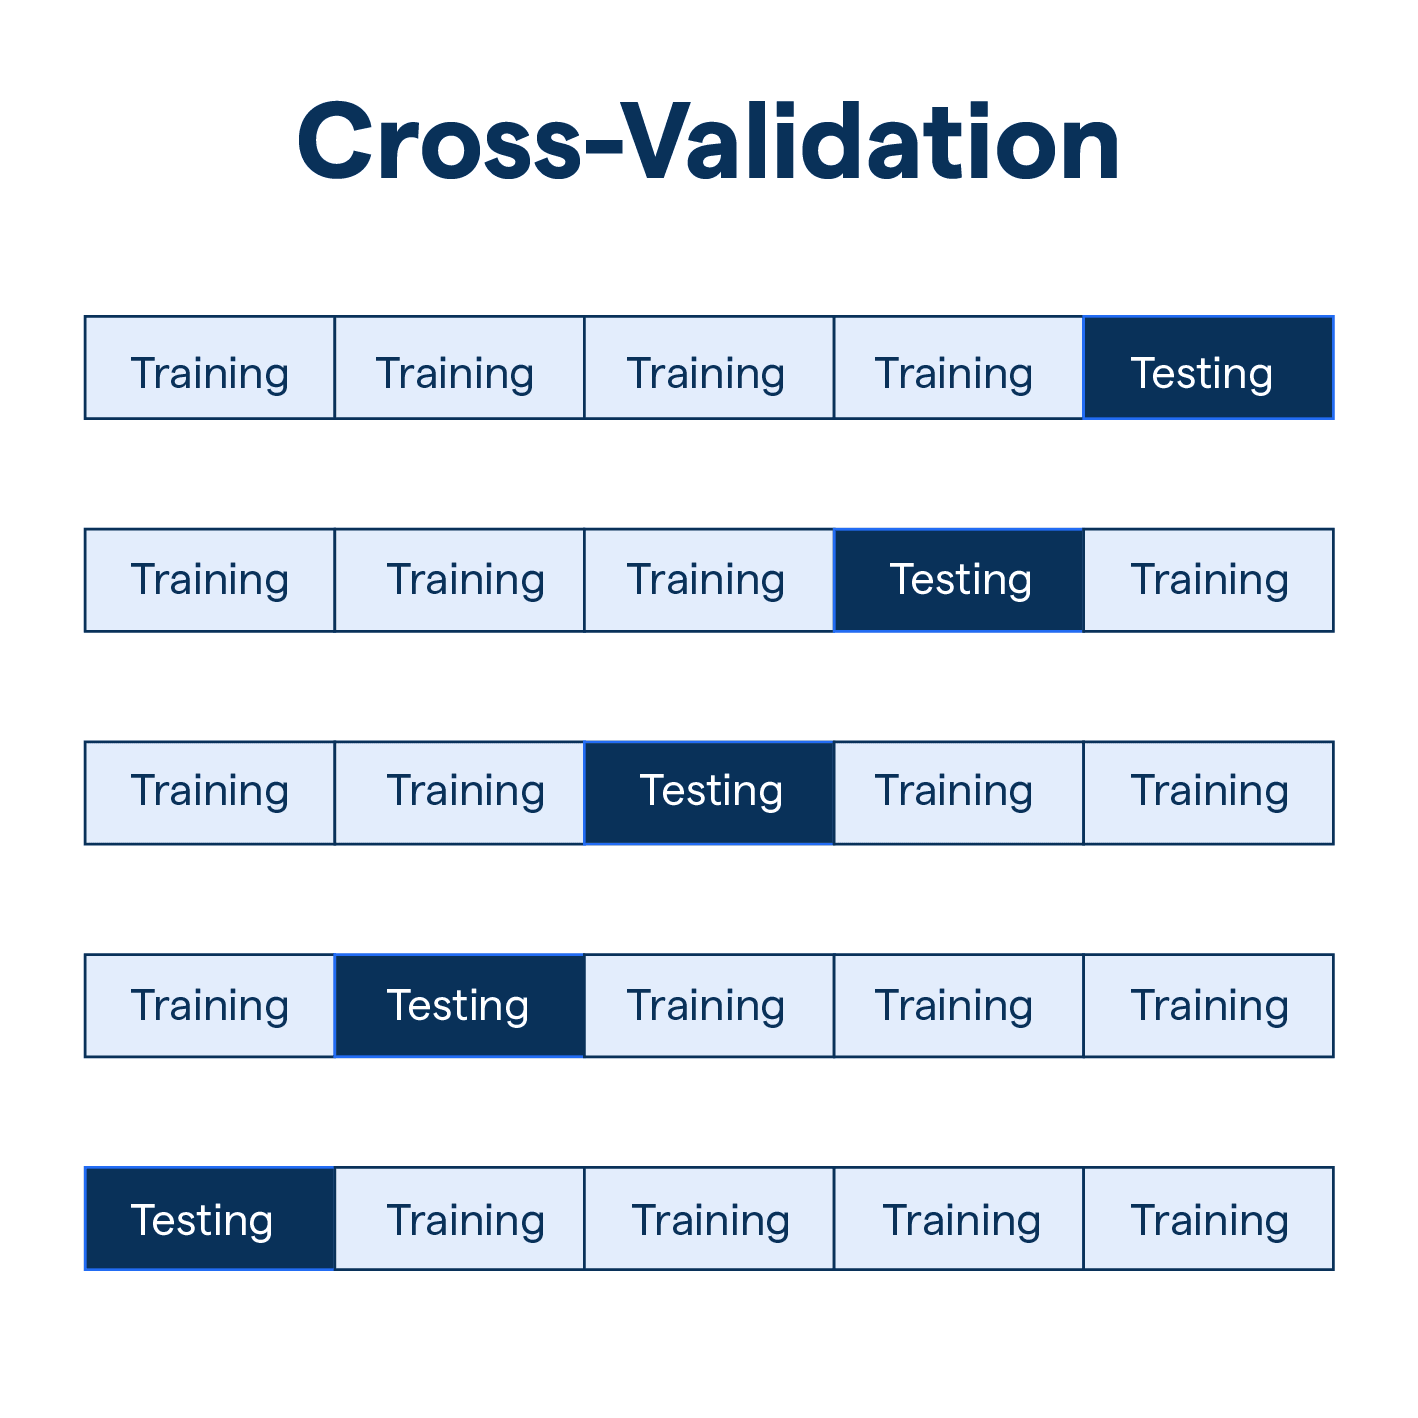

### Example using Cross Validation

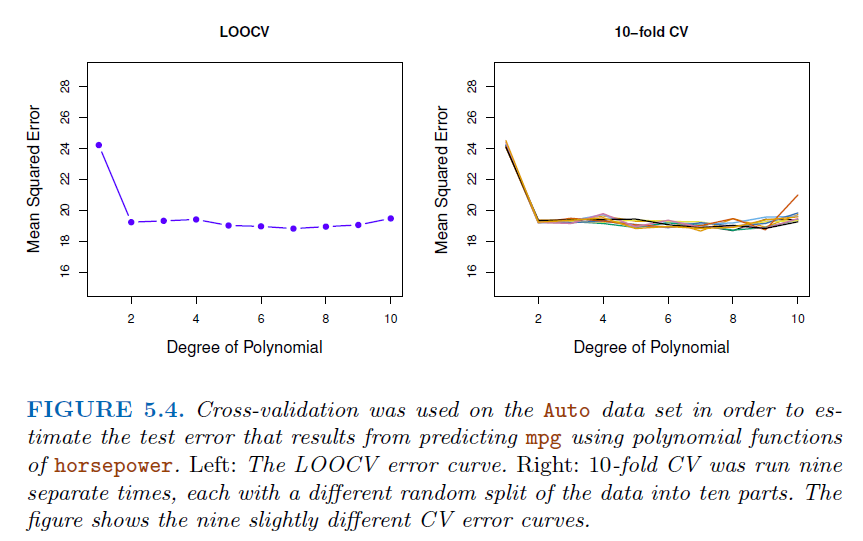



### Common mistakes in Cross Validation
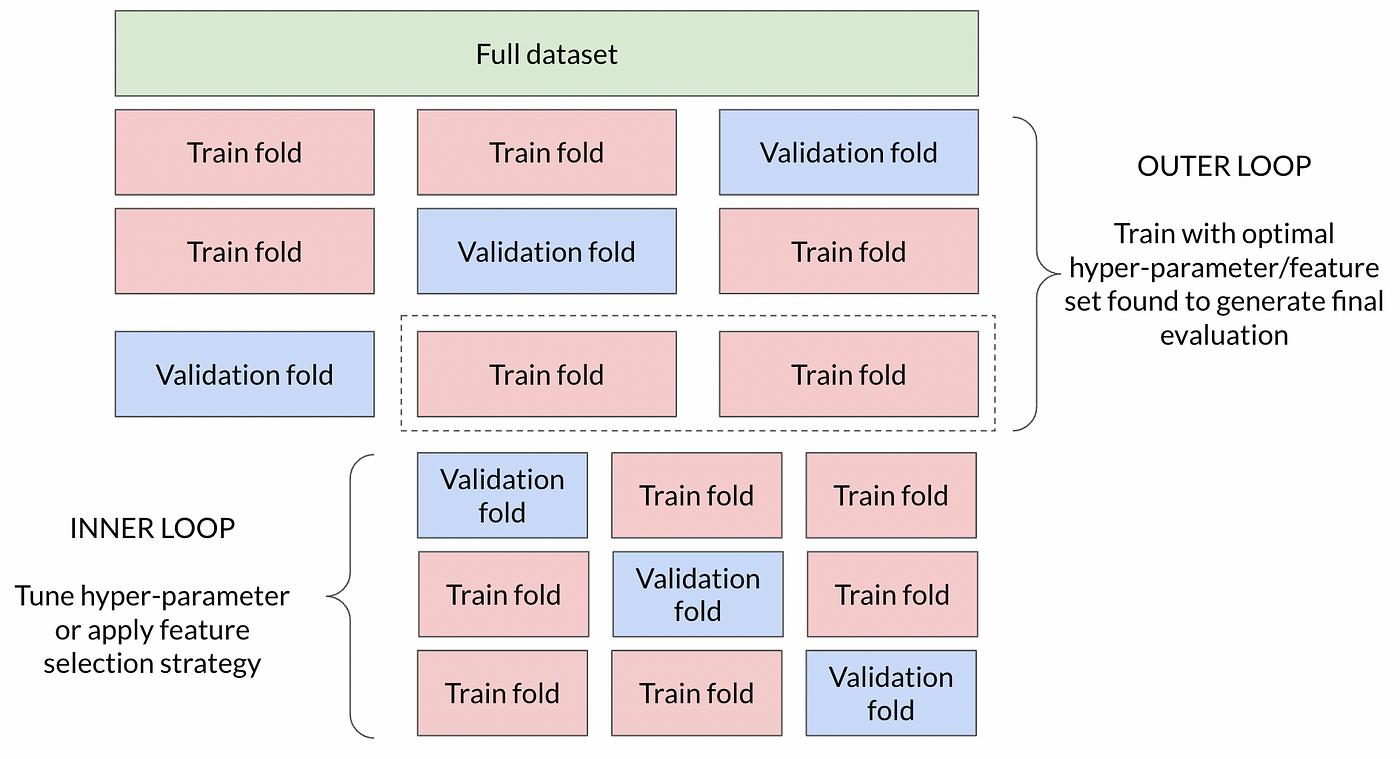
#### **Feature selection before Cross validation**
* Performing feature selection before cross-validation can lead to data leakage and overfitting, as you're peeking at the entire dataset to select features based on their correlation with the target variable.
* This can result in **overly optimistic performance estimates**.
#### Example
* We randomly generate 50 predictors with different mean and variance normal distribution, and random label Y 
* We select 5 predictors having the largest correlation with the radom label
* Then we put this 5 predictors into logistic regression to get CV Score
* Theoretically, we will get CV score around 50% since the independent simulation, but result gives us much higher score

In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import pearsonr

In [4]:
# Set random seed for reproducibility
np.random.seed(5)

# Generate X with 50 random arrays following normal distribution with different mean and variance
X = np.random.normal(loc=np.random.uniform(-10, 10, size=50), scale=np.random.uniform(1, 5, size=50), size=(100, 50))

# Generate y as random labels from uniform distribution
y = np.random.randint(2, size=100)

# Step 2: Select the 5 features most correlated with the outcome
## This step is wrong since model have seen 
## all labels to get most correlated predictors
correlations = np.array([pearsonr(X[:, i], y)[0] for i in range(X.shape[1])])
top_five_indices = np.argsort(np.abs(correlations))[-5:]

# Step 3: Perform cross-validation using only the selected features
selected_X = X[:, top_five_indices]
model = LogisticRegression()

# Use cross-validation to estimate the test error
cv_scores = cross_val_score(model, selected_X, y, cv=5)

# The mean cross-validated score can be misleadingly high due to feature selection bias
mean_cv_score = np.mean(cv_scores)
print("Cross-validation scores:", cv_scores)
print(f'Mean CV score: {mean_cv_score}')

Cross-validation scores: [0.55 0.7  0.45 0.75 0.75]
Mean CV score: 0.64


## Bootstrap
* The `bootstrap` is a flexible and powerful statistical tool that can be used to **quantify the uncertainty associated with a given estimator or statistical learning method**.
    * For example, it provides the estimate of standard error of a coefficient, or a confidence interval for that coefficient.

### Example for Bootstrap
* We want to invest our money in two financial assets that yield returns of X and Y
* We will invest a fraction $\alpha$ of our money in $X$, and $1-\alpha$ in Y
* We wish to choose $\alpha$ to minimize the total risk, or variance ($Var(\alpha X+(1-\alpha)Y)$), of our investment. 
$$
Var(\alpha X+(1-\alpha)Y) = \alpha ^2Var(X) + (1-\alpha)^2 Var(Y) + 2\alpha(1-\alpha) CoV(XY)
$$
$$
\frac{\partial f}{\partial \alpha} = 2\alpha Var(x) - 2(1-\alpha) Var(Y) + 2(1-\alpha) CoV(XY) - 2\alpha(XY)
$$
* Let $\frac{\partial f}{\partial \alpha}  = 0$, we get
$$
\alpha = \frac{Var(Y)-Cov(XY)}{Var(X)+Var(Y)-2CoV(XY)}
$$
* We can estimate $Var(X), Var(Y)$ and $CoV(XY)$ using sampling / simulation

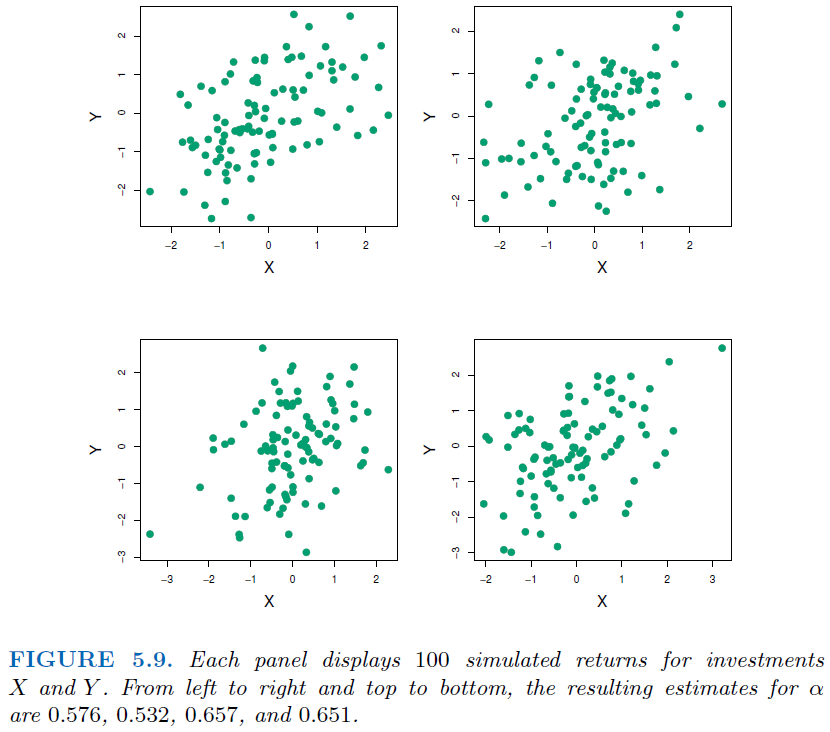
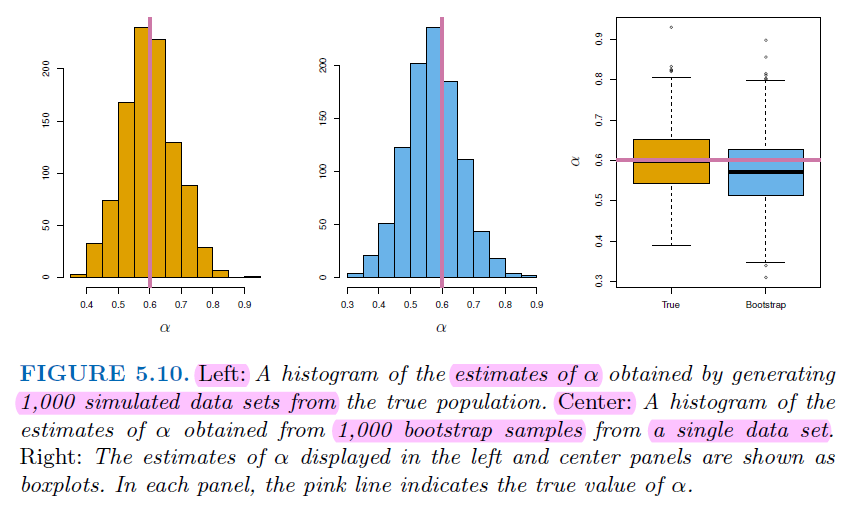

### Why we need Bootstrap
1. In real word analysis, we cannot generate new samples from the original population.
    - Bootstrap allows us to mimic the process of obtaining new data sets. So we can estimate the variability of our estimate without generating additional samples
    - Each bootstrap datasets is created by **sampling with replacement**, and is the **same size** as the original dataset.
    - There is about a **two-thirds overlap** in a bootstrap sample with the original data
    
    1. Assume we 

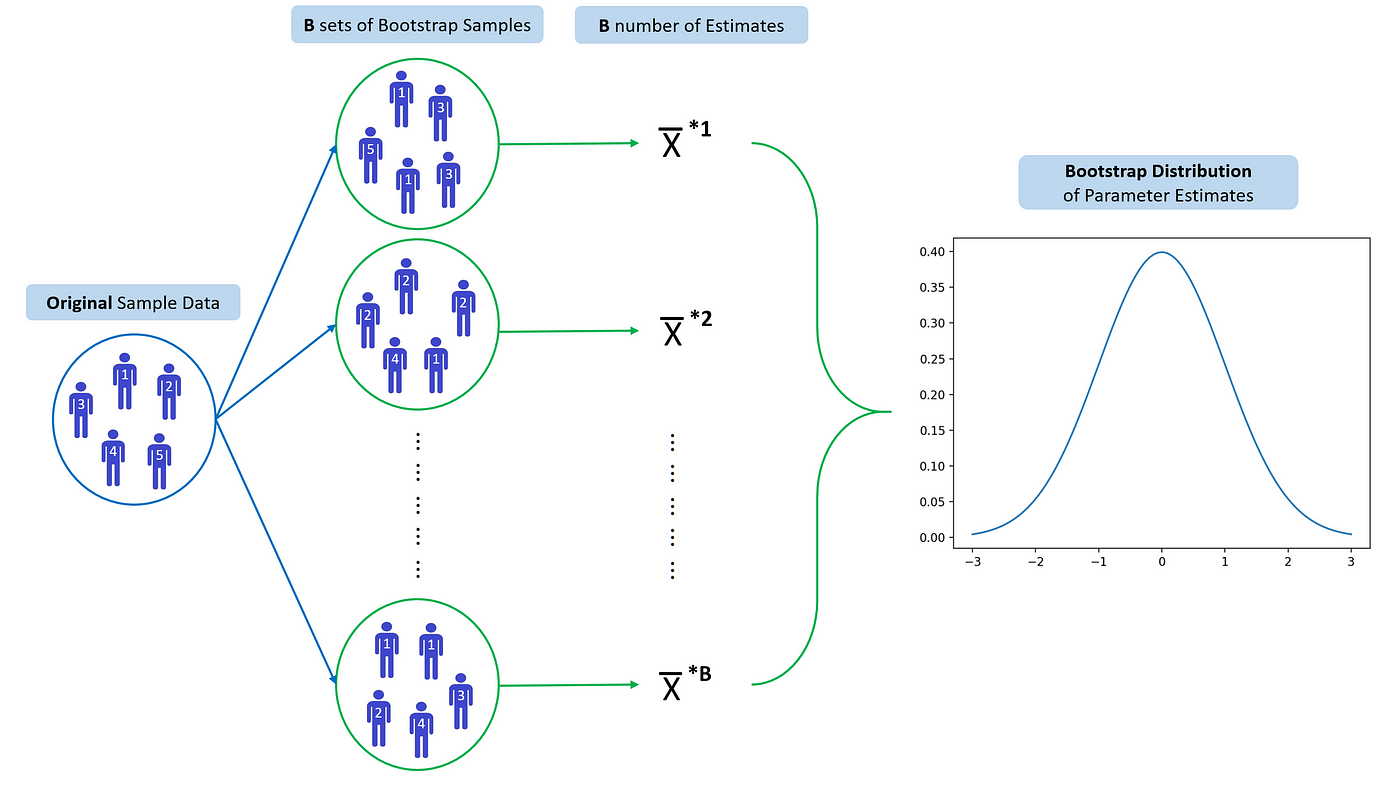

2. Bootstrap **requires data being independent to each other**, some data like time series are not applicable for Bootstrap
    * For time series, we can divide data by blocks, then use block to do bootstrap
    
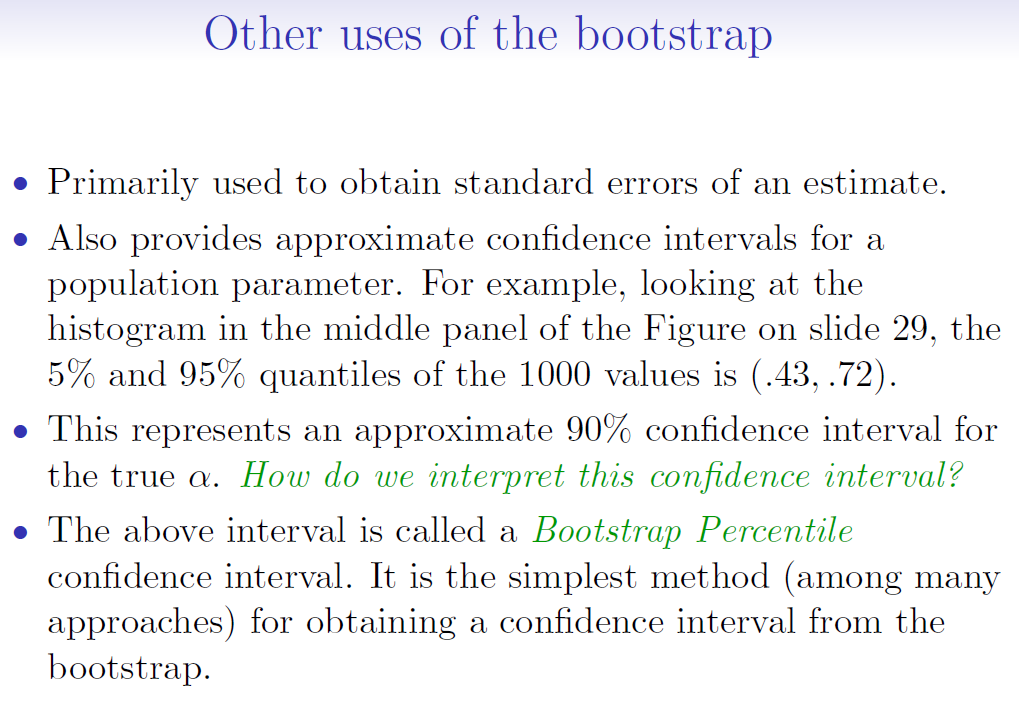